#### BatteryManager Processer script

In [282]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re

HEADER_PATTERN = 'BatteryMgr:DataCollectionService: onStartCommand: rawFields => '
DATA_PATTERN = 'BatteryMgr:DataCollectionService: stats => '

def preprocess_values(df):
    df['Timestamp'] = df['Timestamp'] - df['Timestamp'][0]
    # conversion from microseconds to seconds
    df['Timestamp'] = df['Timestamp'] / 1000
    return df

def calculate_power(df):
    df['power'] = (abs(df['BATTERY_PROPERTY_CURRENT_NOW']) / 1000 / 1000) * (df['EXTRA_VOLTAGE'] / 1000)
    return df

def trapezoid_method(df):
    return np.trapz(df['power'].values, df['Timestamp'].values), df['Timestamp'].values[-1]


def get_column_names(file):
    pattern = re.compile(HEADER_PATTERN)
    cols = []
    for line in open(file, encoding='utf-16'):
        if pattern.search(line):
            cols = line.split(HEADER_PATTERN)[1].split(',')
            cols = [col.strip() for col in cols]
            break
    return cols

def get_data(file):
    pattern = re.compile(DATA_PATTERN)
    data = []
    for line in open(file, encoding='utf-16'):
        if pattern.search(line):
            data.append(line.split(DATA_PATTERN)[1].strip('\n').split(','))

    return data

def generate_csv(data_path):
    cols = get_column_names(data_path)
    data = get_data(data_path)
    df = pd.DataFrame(data, columns=cols)
    # df.to_csv('test-paul-controls-bs3/batterymanager.csv', index=False)
    df['Timestamp'] = np.int64(df['Timestamp'])
    df['BATTERY_PROPERTY_CURRENT_NOW'] = np.int64(df['BATTERY_PROPERTY_CURRENT_NOW'])
    df['EXTRA_VOLTAGE'] = np.int64(df['EXTRA_VOLTAGE'])
    df = preprocess_values(df)
    df = calculate_power(df)
    # print(RAW_DATA)
    # print("Energy (J) = ", trapezoid_method(df))
    # print('Data path ', data_path.strip('.log') + '.csv')
    df.to_csv('.\\' + data_path.strip('.log') + '.csv', index=False)
    return df

def choose_repetition_type(repetition):
    if 'baseline' in repetition:
        return 'baseline'
    elif 'replay' in repetition:
        return 'replay'
    return 'record'

def set_run_number(repetition):
    return repetition.strip(choose_repetition_type(repetition))

def process_BM(folder):

    folder_num = len(folder.split('\\'))

    df_aggregated = pd.DataFrame(columns=['device', 'app', 'app_details', 'is_record', 'is_wireless', 'repetition', 'energy(J)', 'length(s)'])
    for root, dirs, files in os.walk(".", topdown=False):
        for name in files:
            if (folder in root) and (name == 'battery_manager.log'):
                print(os.path.join(root, name))
                energy, length = trapezoid_method(generate_csv(os.path.join(root, name)))
                device = root.split('\\')[1 + folder_num]
                app = root.split('\\')[2 + folder_num].strip('-W')
                app_details = root.split('\\')[3 + folder_num]
                is_record = choose_repetition_type(root.split('\\')[4 + folder_num])
                is_wireless = '-W' in root.split('\\')[2 + folder_num]
                repetition = set_run_number(root.split('\\')[4 + folder_num])
                df_aggregated = pd.concat([df_aggregated, pd.DataFrame([[device, app, app_details, is_record, is_wireless, repetition, energy, length]], columns=['device', 'app', 'app_details', 'is_record', 'is_wireless', 'repetition', 'energy(J)', 'length(s)'])])

    # normalized energy consumption for better comparison
    df_aggregated['Energy per Second (J/s)'] = df_aggregated['energy(J)'] / df_aggregated['length(s)']
    return df_aggregated

In [283]:
process_BM('overhead-validation')

.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\baseline0\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\baseline1\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\baseline2\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\record0\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\record1\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\record2\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.0\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.1\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.2\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.3\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.4\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\repl

C:\Users\radua\AppData\Local\Temp\ipykernel_24200\3710284023.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_aggregated = pd.concat([df_aggregated, pd.DataFrame([[device, app, app_details, is_record, is_wireless, repetition, energy, length]], columns=['device', 'app', 'app_details', 'is_record', 'is_wireless', 'repetition', 'energy(J)', 'length(s)'])])


,device,app,app_details,is_record,is_wireless,repetition,energy(J),length(s),Energy per Second (J/s)
0,Quest-2,BeatSaber,PopStars-Medium,baseline,False,0,1637.629356,260.211,6.293467
0,Quest-2,BeatSaber,PopStars-Medium,baseline,False,1,1646.405497,258.065,6.379809
0,Quest-2,BeatSaber,PopStars-Medium,baseline,False,2,1614.135229,255.879,6.308197
0,Quest-2,BeatSaber,PopStars-Medium,record,False,0,1605.080273,256.239,6.263997
0,Quest-2,BeatSaber,PopStars-Medium,record,False,1,1617.171011,257.057,6.291099
...,...,...,...,...,...,...,...,...,...
0,Quest-Pro,BeatSaber,PopStars-Medium,replay,False,2.5,1938.200760,278.679,6.954958
0,Quest-Pro,BeatSaber,PopStars-Medium,replay,False,2.6,1944.126547,276.649,7.027412
0,Quest-Pro,BeatSaber,PopStars-Medium,replay,False,2.7,1956.434517,279.637,6.996336
0,Quest-Pro,BeatSaber,PopStars-Medium,replay,False,2.8,1954.692140,278.605,7.015998


In [284]:
bm = process_BM('overhead-validation').reset_index(drop=True)
# bm.to_csv('overall_energy.csv', index=False)

.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\baseline0\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\baseline1\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\baseline2\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\record0\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\record1\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\record2\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.0\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.1\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.2\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.3\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.4\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\repl

C:\Users\radua\AppData\Local\Temp\ipykernel_24200\3710284023.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_aggregated = pd.concat([df_aggregated, pd.DataFrame([[device, app, app_details, is_record, is_wireless, repetition, energy, length]], columns=['device', 'app', 'app_details', 'is_record', 'is_wireless', 'repetition', 'energy(J)', 'length(s)'])])


In [285]:
bm

,device,app,app_details,is_record,is_wireless,repetition,energy(J),length(s),Energy per Second (J/s)
0,Quest-2,BeatSaber,PopStars-Medium,baseline,False,0,1637.629356,260.211,6.293467
1,Quest-2,BeatSaber,PopStars-Medium,baseline,False,1,1646.405497,258.065,6.379809
2,Quest-2,BeatSaber,PopStars-Medium,baseline,False,2,1614.135229,255.879,6.308197
3,Quest-2,BeatSaber,PopStars-Medium,record,False,0,1605.080273,256.239,6.263997
4,Quest-2,BeatSaber,PopStars-Medium,record,False,1,1617.171011,257.057,6.291099
...,...,...,...,...,...,...,...,...,...
67,Quest-Pro,BeatSaber,PopStars-Medium,replay,False,2.5,1938.200760,278.679,6.954958
68,Quest-Pro,BeatSaber,PopStars-Medium,replay,False,2.6,1944.126547,276.649,7.027412
69,Quest-Pro,BeatSaber,PopStars-Medium,replay,False,2.7,1956.434517,279.637,6.996336
70,Quest-Pro,BeatSaber,PopStars-Medium,replay,False,2.8,1954.692140,278.605,7.015998


# Plots

### Setting Figure Style

In [286]:
plt.rcParams['font.family'] = 'Arial'
custom_params = {"axes.spines.right": False, 
                 "axes.spines.top": False,
                 "axes.spines.left": True,
                 "axes.spines.bottom": True,
                #create dashes next to ticks
                 "xtick.bottom": True,
                 "ytick.left": True,
                
                 "axes.edgecolor": "black",

                 "axes.grid": True,
                 "axes.linewidth": 1.5, 
                 "axes.facecolor": "white", 
                 "grid.color": "lightgray",
                 
                 }
# custom_params = {}

sns.set_theme(style="whitegrid", rc=custom_params)
sns.set_palette("deep")

custom_mean = {"marker":"d",
                "markerfacecolor":"white", 
                "markeredgecolor":"black",
                "markersize":"7"}

custom_outliers = {'marker': 'o', 
                   'markerfacecolor': 'grey'}

### Totals per device

C:\Users\radua\AppData\Local\Temp\ipykernel_24200\1886722613.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=bm, x='device', y='Energy per Second (J/s)', showmeans=True, meanprops=custom_mean, palette='colorblind', flierprops=custom_outliers)


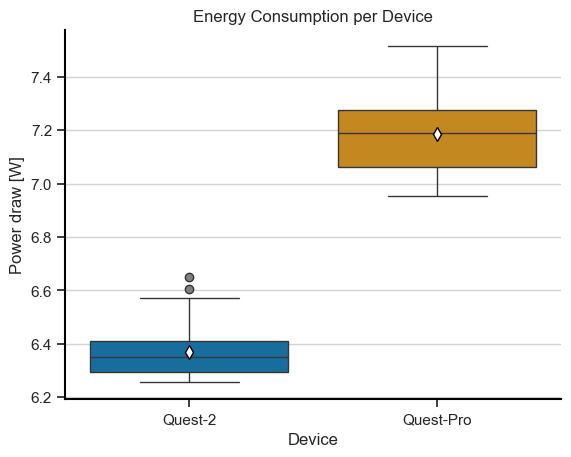

In [287]:
sns.boxplot(data=bm, x='device', y='Energy per Second (J/s)', showmeans=True, meanprops=custom_mean, palette='colorblind', flierprops=custom_outliers)
plt.ylabel('Power draw [W]')
plt.xlabel('Device')
plt.title('Energy Consumption per Device')
plt.show()

### Energy Consumption per Device and App

C:\Users\radua\AppData\Local\Temp\ipykernel_24200\202131142.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['device'] == device], x='Energy per Second (J/s)', y='is_record', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind', flierprops=custom_outliers)
C:\Users\radua\AppData\Local\Temp\ipykernel_24200\202131142.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['device'] == device], x='Energy per Second (J/s)', y='is_record', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind', flierprops=custom_outliers)


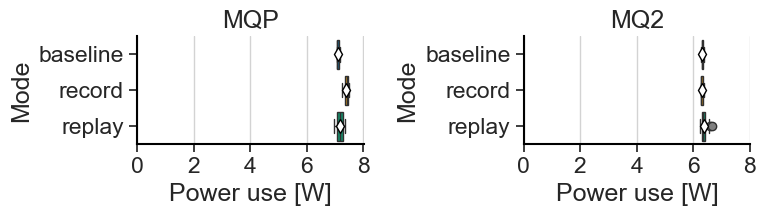

Quest 2 baseline avg 6.327157913530805 W
Quest 2 record avg 6.310491307737119 W
Quest 2 replay avg 6.377087534834221 W
Quest Pro baseline avg 7.106367051734549 W
Quest Pro record avg 7.400603999367426 W
Quest Pro replay avg 7.1714281538051505 W
Quest Pro max diff 0.29423694763287767 W
Quest 2 max diff 0.06659622709710167 W


In [288]:

def plot_apps_by_device(df, out_folder):
    unique_devices = ['Quest-Pro', 'Quest-2']
    num_devices = len(unique_devices)
    fig, axes = plt.subplots(1, num_devices, figsize=(8, 2.5))
    min_energy = df['Energy per Second (J/s)'].min() - 0.5
    max_energy = df['Energy per Second (J/s)'].max() + 0.5
    
    for i, device in enumerate(unique_devices):
        ax = axes[i]
        # sns.set_style("whitegrid", {'axes.grid' : True, 'grid.color': '0.5'})
        sns.boxplot(data=df[df['device'] == device], x='Energy per Second (J/s)', y='is_record', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind', flierprops=custom_outliers)
        
        # ax.set_facecolor("white")
        # ax.spines['bottom'].set_color('0.5')
        # ax.spines['top'].set_color(None)
        # ax.spines['right'].set_color(None)
        # ax.spines['left'].set_color('0.5')
        
        ax.set_xlabel('Power use [W]')
        ax.set_ylabel('Mode')
        ax.set_xticks([0,2,4,6,8])
        if device == 'Quest-Pro':
            ax.set_title('MQP')
        else:
            ax.set_title('MQ2')
        # ax.set_title(device.replace('-', ' '))

        ax.set_xlim(0, max_energy)
    
    # fig.suptitle('Energy Consumption Comparison')
    plt.tight_layout()
    plt.savefig(f'./figures/{out_folder}/val_energy.pdf', bbox_inches='tight', format='pdf')
    plt.show()

# sns.set(font_scale=1.5)
sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.5)
plot_apps_by_device(bm, 'validation')

# find min and max average energy consumption per record per device
print('Quest 2 baseline avg', bm[(bm['is_record'] == 'baseline') & (bm['device'] == 'Quest-2')]['Energy per Second (J/s)'].mean(), 'W')
print('Quest 2 record avg', bm[(bm['is_record'] == 'record') & (bm['device'] == 'Quest-2')]['Energy per Second (J/s)'].mean(), 'W')
print('Quest 2 replay avg', bm[(bm['is_record'] == 'replay') & (bm['device'] == 'Quest-2')]['Energy per Second (J/s)'].mean(), 'W')
print('Quest Pro baseline avg', bm[(bm['is_record'] == 'baseline') & (bm['device'] == 'Quest-Pro')]['Energy per Second (J/s)'].mean(), 'W')
print('Quest Pro record avg', bm[(bm['is_record'] == 'record') & (bm['device'] == 'Quest-Pro')]['Energy per Second (J/s)'].mean(), 'W')
print('Quest Pro replay avg', bm[(bm['is_record'] == 'replay') & (bm['device'] == 'Quest-Pro')]['Energy per Second (J/s)'].mean(), 'W')

quest_pro_max_diff = bm[(bm['is_record'] == 'record') & (bm['device'] == 'Quest-Pro')]['Energy per Second (J/s)'].mean() - bm[(bm['is_record'] == 'baseline') & (bm['device'] == 'Quest-Pro')]['Energy per Second (J/s)'].mean()
print('Quest Pro max diff', quest_pro_max_diff, 'W')
quest_2_max_diff = bm[(bm['is_record'] == 'replay') & (bm['device'] == 'Quest-2')]['Energy per Second (J/s)'].mean() - bm[(bm['is_record'] == 'record') & (bm['device'] == 'Quest-2')]['Energy per Second (J/s)'].mean()
print('Quest 2 max diff', quest_2_max_diff, 'W')

In [289]:
bm = bm[bm['app'] != 'PistolWhip']

In [290]:
def plot_traces_per_device(df, device):
    df = df[df['device'] == device]
    unique_apps = df['is_wireless'].unique()
    num_apps = len(unique_apps)
    fig, axes = plt.subplots(1, num_apps, figsize=(5.25*num_apps, 7))
    min_energy = df['Energy per Second (J/s)'].min() - 0.5
    max_energy = df['Energy per Second (J/s)'].max() + 0.5    
    
    for i, wireless in enumerate(unique_apps):
        ax = axes[i]
        sns.boxplot(data=df[df['is_wireless'] == wireless], x='app_details', y='Energy per Second (J/s)', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind', flierprops=custom_outliers)
        if wireless:
            ax.set_title('Energy Consumption of Wireless Traces on ' + device)
        else:
            ax.set_title('Energy Consumption of Cabled Traces on ' + device)
        ax.set_ylabel('Power use [W]')
        ax.set_xlabel('Trace')

        ax.set_ylim(0, max_energy)
    fig.suptitle('Energy Consumption of Traces on ' + device)
    plt.tight_layout()
    plt.show()

sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.5)

# plot_traces_per_device(bm, 'Quest-2')
# plot_traces_per_device(bm, 'Quest-Pro')

.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\record0\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.0\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.1\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.2\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.3\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.4\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.5\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.6\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.7\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.8\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.9\battery_manager.log
.\swap-vr\Quest-Pro\BeatSaber\PopStars-Medium\record0\battery_manager.log
.\swap-vr\Quest-Pro\BeatSaber\PopStars-Medium\replay0.0\battery_manager.log
.\swap-vr\Quest-Pro\BeatSaber\PopStars

C:\Users\radua\AppData\Local\Temp\ipykernel_24200\3710284023.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_aggregated = pd.concat([df_aggregated, pd.DataFrame([[device, app, app_details, is_record, is_wireless, repetition, energy, length]], columns=['device', 'app', 'app_details', 'is_record', 'is_wireless', 'repetition', 'energy(J)', 'length(s)'])])
C:\Users\radua\AppData\Local\Temp\ipykernel_24200\202131142.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['device'] == device], x='Energy per Second (J/s)', y='is_record', showmeans=True, meanprops=custom_mean, ax=ax, 

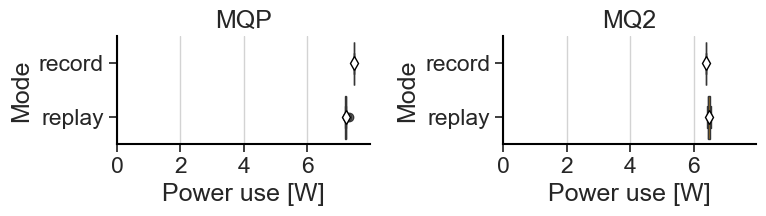

Quest 2 PC-B baseline avg 6.327157913530805 W
Quest 2 PC-B record avg 6.310491307737119 W
Quest 2 PC-B replay avg 6.377087534834221 W
Quest 2 PC-A record avg 6.407867818896804 W
Quest 2 PC-A replay avg 6.481947396179848 W
Quest 2 setup max diff 0.17145608844272875 W
Quest Pro PC-B baseline avg 7.106367051734549 W
Quest Pro PC-B record avg 7.400603999367426 W
Quest Pro PC-B replay avg 7.1714281538051505 W
Quest Pro PC-A record avg 7.470916321507373 W
Quest Pro PC-A replay avg 7.229106915420701 W
Quest Pro setup max diff 0.36454926977282387 W


In [291]:
swap_bm = process_BM('swap-vr').reset_index(drop=True)
sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.5)

plot_apps_by_device(swap_bm, 'swap')

print('Quest 2 PC-B baseline avg', bm[(bm['is_record'] == 'baseline') & (bm['device'] == 'Quest-2')]['Energy per Second (J/s)'].mean(), 'W')
print('Quest 2 PC-B record avg', bm[(bm['is_record'] == 'record') & (bm['device'] == 'Quest-2')]['Energy per Second (J/s)'].mean(), 'W')
print('Quest 2 PC-B replay avg', bm[(bm['is_record'] == 'replay') & (bm['device'] == 'Quest-2')]['Energy per Second (J/s)'].mean(), 'W')

print('Quest 2 PC-A record avg', swap_bm[(swap_bm['is_record'] == 'record') & (swap_bm['device'] == 'Quest-2')]['Energy per Second (J/s)'].mean(), 'W')
print('Quest 2 PC-A replay avg', swap_bm[(swap_bm['is_record'] == 'replay') & (swap_bm['device'] == 'Quest-2')]['Energy per Second (J/s)'].mean(), 'W')

q2_setup_max_diff = swap_bm[(swap_bm['is_record'] == 'replay') & (swap_bm['device'] == 'Quest-2')]['Energy per Second (J/s)'].mean() - bm[(bm['is_record'] == 'record') & (bm['device'] == 'Quest-2')]['Energy per Second (J/s)'].mean()
print('Quest 2 setup max diff', q2_setup_max_diff, 'W')


print('Quest Pro PC-B baseline avg', bm[(bm['is_record'] == 'baseline') & (bm['device'] == 'Quest-Pro')]['Energy per Second (J/s)'].mean(), 'W')
print('Quest Pro PC-B record avg', bm[(bm['is_record'] == 'record') & (bm['device'] == 'Quest-Pro')]['Energy per Second (J/s)'].mean(), 'W')
print('Quest Pro PC-B replay avg', bm[(bm['is_record'] == 'replay') & (bm['device'] == 'Quest-Pro')]['Energy per Second (J/s)'].mean(), 'W')

print('Quest Pro PC-A record avg', swap_bm[(swap_bm['is_record'] == 'record') & (swap_bm['device'] == 'Quest-Pro')]['Energy per Second (J/s)'].mean(), 'W')
print('Quest Pro PC-A replay avg', swap_bm[(swap_bm['is_record'] == 'replay') & (swap_bm['device'] == 'Quest-Pro')]['Energy per Second (J/s)'].mean(), 'W')

qPro_setup_max_diff = swap_bm[(swap_bm['is_record'] == 'record') & (swap_bm['device'] == 'Quest-Pro')]['Energy per Second (J/s)'].mean() - bm[(bm['is_record'] == 'baseline') & (bm['device'] == 'Quest-Pro')]['Energy per Second (J/s)'].mean()
print('Quest Pro setup max diff', qPro_setup_max_diff, 'W')

## CPU GPU Validation

In [292]:

def get_cpu_gpu_data(path, folder_num):
    df = pd.DataFrame(columns=['device', 'app', 'is_record', 'repetition', 'timestamp_cpu', 'timestamp_gpu', 'cpu_usage', 'gpu_usage'])
    df['gpu_usage'] = pd.read_csv(path)['memoryUtil']
    df['timestamp_gpu'] = pd.read_csv(path)['timestamp']

    cpu_path = path.replace('host_gpu_metrics.log', 'host_sys_metrics.log')
    df['cpu_usage'] = pd.read_csv(cpu_path)['cpu.percent']
    df['timestamp_cpu'] = pd.read_csv(cpu_path)['timestamp']

    df['device'] = path.split('\\')[1 + folder_num]
    df['app'] = path.split('\\')[2 + folder_num].strip('-W')
    df['is_record'] = choose_repetition_type(path.split('\\')[4 + folder_num])
    df['repetition'] = set_run_number(path.split('\\')[4 + folder_num])
    
    return df


def process_cpu_gpu(folder):

    folder_num = len(folder.split('\\'))

    df_aggregated = pd.DataFrame(columns=['device', 'app', 'is_record', 'repetition', 'timestamp_cpu', 'timestamp_gpu', 'cpu_usage', 'gpu_usage'])
    for root, dirs, files in os.walk(".", topdown=False):
        for file in files:
            if (folder in root):
                if file == 'host_gpu_metrics.log':
                    path = os.path.join(root, file)
                    temp = get_cpu_gpu_data(path, folder_num)
                    df_aggregated = pd.concat([df_aggregated, temp])
                    
                # print(os.path.join(root, name))
                
    # normalized energy consumption for better comparison
    # df_aggregated['Energy per Second (J/s)'] = df_aggregated['energy(J)'] / df_aggregated['length(s)']
    df_aggregated['gpu_usage'] = df_aggregated['gpu_usage'] * 100
    return df_aggregated

wa = process_cpu_gpu('overhead-validation')

C:\Users\radua\AppData\Local\Temp\ipykernel_24200\863157488.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_aggregated = pd.concat([df_aggregated, temp])


In [293]:
sns.set(font_scale=1.5)

def plot_gpu_usage(df, out_folder):
    unique_devices = df['device'].unique()[:2]
    num_devices = len(unique_devices)
    fig, axes = plt.subplots(1, num_devices, figsize=(8, 2.5))
    min_energy = df['gpu_usage'].min() - 0.5
    max_energy = df['gpu_usage'].max() + 5
    unique_devices = reversed(unique_devices)
    
    for i, device in enumerate(unique_devices):
        ax = axes[i]
        sns.boxplot(data=df[df['device'] == device], x='gpu_usage', y='is_record', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind', flierprops=custom_outliers)
        ax.set_xlabel('GPU usage [%]')
        ax.set_ylabel('Mode')
        cmp = 'Quest-2'
        if 'swap' in out_folder:
            cmp = 'Quest-Pro'

        if device == cmp:
            ax.set_title("PC-B (running " + device.replace("-", " ") + ")")
        else:
            ax.set_title("PC-A (running " + device.replace("-", " ") + ")")
        
        ax.set_xticks([0,10,20,30,40,50])

        ax.set_xlim(0, max_energy)
    
    # fig.suptitle('GPU usage Comparison')
    plt.tight_layout()
    plt.savefig(f'./figures/{out_folder}/val_gpu.pdf', bbox_inches='tight', format='pdf')
    plt.show()


def plot_cpu_usage(df, out_folder):
    unique_devices = df['device'].unique()[:2]
    num_devices = len(unique_devices)
    fig, axes = plt.subplots(1, num_devices, figsize=(8, 2.5))
    min_energy = df['cpu_usage'].min() - 0.5
    max_energy = df['cpu_usage'].max() + 5
    unique_devices = reversed(unique_devices)
    
    for i, device in enumerate(unique_devices):
        ax = axes[i]
        sns.boxplot(data=df[df['device'] == device], x='cpu_usage', y='is_record', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind', flierprops=custom_outliers)
        ax.set_xlabel('CPU usage [%]')
        ax.set_ylabel('Mode')
        cmp = 'MQ2'
        if 'swap' in out_folder:
            cmp = 'MQP'

        if device == "Quest-Pro":
            device = "MQP"
        else:
            device = "MQ2"
            
        if device == cmp:
            ax.set_title("PC-B (running " + device + ")")
        else:
            ax.set_title("PC-A (running " + device.replace("-", " ") + ")")
        
        ax.set_xticks([0,10,20,30,40,50])
        
        ax.set_xlim(0, max_energy)
    
    # fig.suptitle('CPU usage Comparison')
    plt.tight_layout()
    plt.savefig(f'./figures/{out_folder}/val_cpu.pdf', bbox_inches='tight', format='pdf')
    plt.show()

C:\Users\radua\AppData\Local\Temp\ipykernel_24200\3396269865.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['device'] == device], x='cpu_usage', y='is_record', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind', flierprops=custom_outliers)
C:\Users\radua\AppData\Local\Temp\ipykernel_24200\3396269865.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['device'] == device], x='cpu_usage', y='is_record', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind', flierprops=custom_outliers)


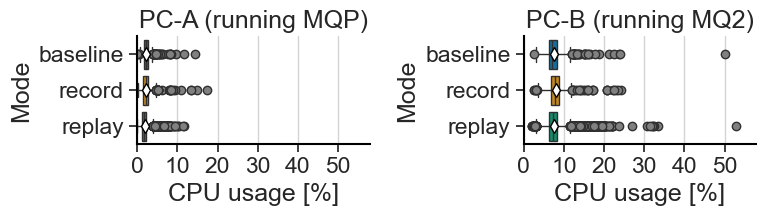

C:\Users\radua\AppData\Local\Temp\ipykernel_24200\3396269865.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['device'] == device], x='gpu_usage', y='is_record', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind', flierprops=custom_outliers)
C:\Users\radua\AppData\Local\Temp\ipykernel_24200\3396269865.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['device'] == device], x='gpu_usage', y='is_record', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind', flierprops=custom_outliers)


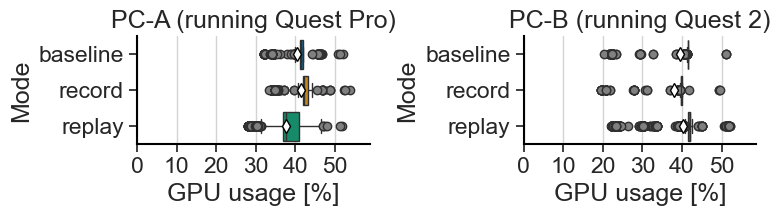

In [294]:
sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.5)

plot_cpu_usage(wa, 'validation')
plot_gpu_usage(wa, 'validation')

C:\Users\radua\AppData\Local\Temp\ipykernel_24200\863157488.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_aggregated = pd.concat([df_aggregated, temp])
C:\Users\radua\AppData\Local\Temp\ipykernel_24200\3396269865.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['device'] == device], x='gpu_usage', y='is_record', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind', flierprops=custom_outliers)
C:\Users\radua\AppData\Local\Temp\ipykernel_24200\3396269865.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in 

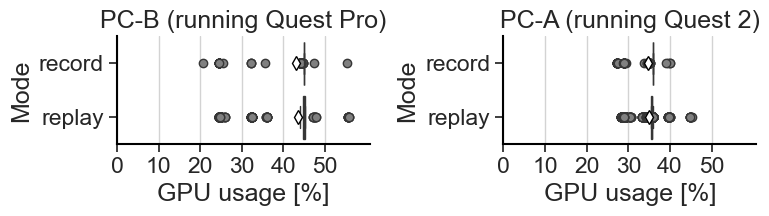

C:\Users\radua\AppData\Local\Temp\ipykernel_24200\3396269865.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['device'] == device], x='cpu_usage', y='is_record', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind', flierprops=custom_outliers)
C:\Users\radua\AppData\Local\Temp\ipykernel_24200\3396269865.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['device'] == device], x='cpu_usage', y='is_record', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind', flierprops=custom_outliers)


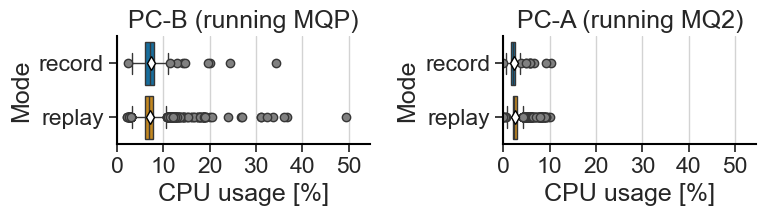

In [295]:
swap = process_cpu_gpu('swap-vr')
plot_gpu_usage(swap, 'swap')
plot_cpu_usage(swap, 'swap')


In [296]:
q2_bl = wa[(wa['device'] == 'Quest-2') & (wa['is_record'] == 'baseline')]['gpu_usage'].describe()
q2_rec = wa[(wa['device'] == 'Quest-2') & (wa['is_record'] == 'record')]['gpu_usage'].describe()
q2_rep = wa[(wa['device'] == 'Quest-2') & (wa['is_record'] == 'replay')]['gpu_usage'].describe()

qp_bl = wa[(wa['device'] == 'Quest-Pro') & (wa['is_record'] == 'baseline')]['gpu_usage'].describe()
qp_rec = wa[(wa['device'] == 'Quest-Pro') & (wa['is_record'] == 'record')]['gpu_usage'].describe()
qp_rep = wa[(wa['device'] == 'Quest-Pro') & (wa['is_record'] == 'replay')]['gpu_usage'].describe()

print('Quest 2 bl diff', q2_bl['75%'] - q2_bl['25%'])
print('Quest 2 rec diff', q2_rec['75%'] - q2_rec['25%'])
print('Quest 2 rep diff', q2_rep['75%'] - q2_rep['25%'])

print('Quest Pro bl diff', qp_bl['75%'] - qp_bl['25%'])
print('Quest Pro rec diff', qp_rec['75%'] - qp_rec['25%'])
print('Quest Pro rep diff', qp_rep['75%'] - qp_rep['25%'])

print('Quest 2 min, max gpu usage', wa[(wa['device'] == 'Quest-2')]['gpu_usage'].min(), wa[(wa['device'] == 'Quest-2')]['gpu_usage'].max())
print('Quest Pro min, max gpu usage', wa[(wa['device'] == 'Quest-Pro')]['gpu_usage'].min(), wa[(wa['device'] == 'Quest-Pro')]['gpu_usage'].max())

Quest 2 bl diff 0.13841393909787314
Quest 2 rec diff 0.1709819247679647
Quest 2 rep diff 0.5862237420615557
Quest Pro bl diff 0.80078125
Quest Pro rec diff 1.19140625
Quest Pro rep diff 3.84765625
Quest 2 min, max gpu usage 19.46751343429409 52.11691906855561
Quest Pro min, max gpu usage 28.115234374999996 53.7109375


# Swap figures redo

In [297]:
wa['experiment'] = 'validation'
# wa[host machine] is PC-A if the device is Quest-Pro
wa['host_machine'] = ['PC-A' if device == 'Quest-Pro' else 'PC-B' for device in wa['device']]

swap['experiment'] = 'swap'
swap['host_machine'] = ['PC-A' if device == 'Quest-2' else 'PC-B' for device in swap['device']]


full_df = pd.concat([wa, swap])

PC-A + Quest 2 record avg 34.74057241586539 W
PC-A + Quest 2 replay avg 35.07368395650658 W
PC-A + Quest Pro record avg 41.47259283685065 W
PC-A + Quest Pro replay avg 37.70367263797867 W


C:\Users\radua\AppData\Local\Temp\ipykernel_24200\541023626.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['device'] = df['device'].apply(lambda x: 'MQ2' if x == 'Quest-2' else 'MQP')
C:\Users\radua\AppData\Local\Temp\ipykernel_24200\541023626.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['is_record'] == rec].sort_values(by='device'), x='gpu_usage', y='device', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind', flierprops=custom_outliers)
C:\Users\radua\AppData\Local\Temp\ipykernel_24200\541023626.py:11: FutureWarning: 

Passing `palette` without assigning

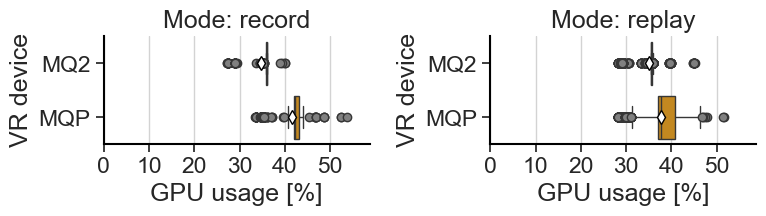

C:\Users\radua\AppData\Local\Temp\ipykernel_24200\541023626.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['device'] = df['device'].apply(lambda x: 'MQ2' if x == 'Quest-2' else 'MQP')
C:\Users\radua\AppData\Local\Temp\ipykernel_24200\541023626.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['is_record'] == rec].sort_values(by='device'), x='cpu_usage', y='device', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind', flierprops=custom_outliers)
C:\Users\radua\AppData\Local\Temp\ipykernel_24200\541023626.py:48: FutureWarning: 

Passing `palette` without assignin

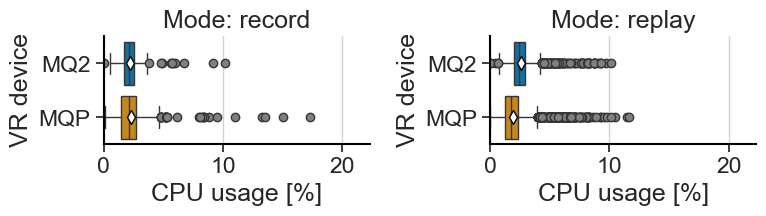

C:\Users\radua\AppData\Local\Temp\ipykernel_24200\541023626.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['device'] = df['device'].apply(lambda x: 'MQ2' if x == 'Quest-2' else 'MQP')
C:\Users\radua\AppData\Local\Temp\ipykernel_24200\541023626.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['is_record'] == rec].sort_values(by='device'), x='gpu_usage', y='device', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind', flierprops=custom_outliers)
C:\Users\radua\AppData\Local\Temp\ipykernel_24200\541023626.py:11: FutureWarning: 

Passing `palette` without assigning

PC-B + Quest 2 record avg 37.98267664072201 W
PC-B + Quest 2 replay avg 40.28665885264572 W
PC-B + Quest Pro record avg 43.105538366896454 W
PC-B + Quest Pro replay avg 43.505138867256235 W


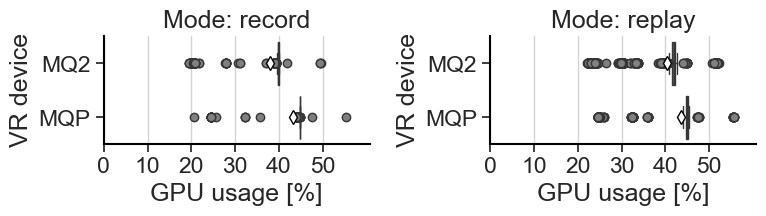

C:\Users\radua\AppData\Local\Temp\ipykernel_24200\541023626.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['device'] = df['device'].apply(lambda x: 'MQ2' if x == 'Quest-2' else 'MQP')
C:\Users\radua\AppData\Local\Temp\ipykernel_24200\541023626.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['is_record'] == rec].sort_values(by='device'), x='cpu_usage', y='device', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind', flierprops=custom_outliers)
C:\Users\radua\AppData\Local\Temp\ipykernel_24200\541023626.py:48: FutureWarning: 

Passing `palette` without assignin

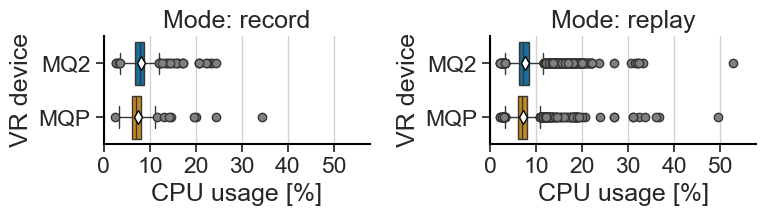

In [298]:
def plot_gpu_usage_pc(df, out_folder):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2.5))
    min_energy = df['gpu_usage'].min() - 0.5
    max_energy = df['gpu_usage'].max() + 5
    is_record_list = ['record', 'replay']
    df['device'] = df['device'].apply(lambda x: 'MQ2' if x == 'Quest-2' else 'MQP')

    
    for i, rec in enumerate(is_record_list):
        ax = axes[i]
        sns.boxplot(data=df[df['is_record'] == rec].sort_values(by='device'), x='gpu_usage', y='device', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind', flierprops=custom_outliers)
        ax.set_xlabel('GPU usage [%]')
        ax.set_ylabel('VR device')

        ax.set_title('Mode: ' + rec)
        
        ax.set_xticks([0,10,20,30,40,50])

        ax.set_xlim(0, max_energy)
    
    host_machine = df['host_machine'].unique()[0]
    # fig.suptitle('GPU usage Comparison')

    rec_q2 = df[(df['is_record'] == 'record') & (df['device'] == 'MQ2')]['gpu_usage'].mean()
    rep_q2 = df[(df['is_record'] == 'replay') & (df['device'] == 'MQ2')]['gpu_usage'].mean()
    rec_qp = df[(df['is_record'] == 'record') & (df['device'] == 'MQP')]['gpu_usage'].mean()
    rep_qp = df[(df['is_record'] == 'replay') & (df['device'] == 'MQP')]['gpu_usage'].mean()

    print(f'{host_machine} + Quest 2 record avg', rec_q2, 'W')
    print(f'{host_machine} + Quest 2 replay avg', rep_q2, 'W')
    print(f'{host_machine} + Quest Pro record avg', rec_qp, 'W')
    print(f'{host_machine} + Quest Pro replay avg', rep_qp, 'W')

    plt.tight_layout()
    plt.savefig(f'./figures/{out_folder}/{host_machine}_device_vs_gpu.pdf', bbox_inches='tight', format='pdf')
    plt.show()


def plot_cpu_usage_pc(df, out_folder):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2.5))
    min_energy = df['cpu_usage'].min() - 0.5
    max_energy = df['cpu_usage'].max() + 5
    is_record_list = ['record', 'replay']
    df['device'] = df['device'].apply(lambda x: 'MQ2' if x == 'Quest-2' else 'MQP')
    
    for i, rec in enumerate(is_record_list):
        ax = axes[i]
        sns.boxplot(data=df[df['is_record'] == rec].sort_values(by='device'), x='cpu_usage', y='device', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind', flierprops=custom_outliers)
        ax.set_xlabel('CPU usage [%]')
        ax.set_ylabel('VR device')

        ax.set_title('Mode: ' + rec)
        
        ax.set_xticks([0,10,20,30,40,50])

        ax.set_xlim(0, max_energy)
    
    host_machine = df['host_machine'].unique()[0]
    # fig.suptitle('CPU usage Comparison')
    plt.tight_layout()
    plt.savefig(f'./figures/{out_folder}/{host_machine}_device_vs_cpu.pdf', bbox_inches='tight', format='pdf')
    plt.show()



plot_gpu_usage_pc(full_df[full_df['host_machine'] == 'PC-A'], 'swap')
plot_cpu_usage_pc(full_df[full_df['host_machine'] == 'PC-A'], 'swap')

plot_gpu_usage_pc(full_df[full_df['host_machine'] == 'PC-B'], 'swap')
plot_cpu_usage_pc(full_df[full_df['host_machine'] == 'PC-B'], 'swap')

## Workload Offloading Experiment Graphs

In [299]:
def get_logcat_api(experiment_folder):
    folder_num = len(experiment_folder.split('\\'))
    df_aggregated = pd.DataFrame()
    for root, dirs, files in os.walk(f"{experiment_folder}", topdown=False):
        for file in files:
            # if (experiment_folder in root):
            if file == 'logcat_VrApi.csv':
                path = os.path.join(root, file)
                temp = pd.read_csv(path)
                temp = temp.rename(columns={'device': 'experiment',
                                            'app': 'device',
                                            'app_details': 'app',
                                            'type': 'repetition',
                                            'repetition': 'app_details'})
                temp['is_record'] = temp['repetition'].apply(lambda x: 'replay' if 'replay' in x else ('record' if 'record' in x else ('baseline' if 'baseline' in x else 'unknown')))

                df_aggregated = pd.concat([df_aggregated, temp])
                print(path)
    return df_aggregated

lc_val = get_logcat_api('overhead-validation')
lc_swap = get_logcat_api('swap-vr')
lc_val['host_machine'] = ['PC-A' if device == 'Quest-Pro' else 'PC-B' for device in lc_val['device']]
lc_swap['host_machine'] = ['PC-A' if device == 'Quest-2' else 'PC-B' for device in lc_swap['device']]
full_lc = pd.concat([lc_swap, lc_val])
full_lc['device'] = full_lc['device'].apply(lambda x: 'MQ2' if x == 'Quest-2' else ('MQP' if x == 'Quest-Pro' else x))

overhead-validation\Quest-2\BeatSaber\PopStars-Medium\baseline0\logcat_VrApi.csv
overhead-validation\Quest-2\BeatSaber\PopStars-Medium\baseline1\logcat_VrApi.csv
overhead-validation\Quest-2\BeatSaber\PopStars-Medium\baseline2\logcat_VrApi.csv
overhead-validation\Quest-2\BeatSaber\PopStars-Medium\record0\logcat_VrApi.csv
overhead-validation\Quest-2\BeatSaber\PopStars-Medium\record1\logcat_VrApi.csv
overhead-validation\Quest-2\BeatSaber\PopStars-Medium\record2\logcat_VrApi.csv
overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.0\logcat_VrApi.csv
overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.1\logcat_VrApi.csv
overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.2\logcat_VrApi.csv
overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.3\logcat_VrApi.csv
overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.4\logcat_VrApi.csv
overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.5\logcat_VrApi.csv
overhead-validation\Quest-2\BeatSa

In [300]:
print(full_lc['device'].nunique())
full_lc['host_machine'].nunique()

2


2

In [301]:
bm['experiment'] = 'validation'
swap_bm['experiment'] = 'swap'

bm['host_machine'] = ['PC-A' if device == 'Quest-Pro' else 'PC-B' for device in bm['device']]
swap_bm['host_machine'] = ['PC-A' if device == 'Quest-2' else 'PC-B' for device in swap_bm['device']]

bm_full = pd.concat([swap_bm, bm])

full_df = pd.merge(full_df, bm_full, on=['device', 'app', 'is_record', 'repetition', 'experiment', 'host_machine'])
# full_df = pd.merge(full_df, full_lc, on=['device', 'app', 'repetition', 'experiment', 'host_machine'])

In [302]:
full_df.columns


Index(['device', 'app', 'is_record', 'repetition', 'timestamp_cpu',
       'timestamp_gpu', 'cpu_usage', 'gpu_usage', 'experiment', 'host_machine',
       'app_details', 'is_wireless', 'energy(J)', 'length(s)',
       'Energy per Second (J/s)'],
      dtype='object')

In [303]:
full_df.head(5)

,device,app,is_record,repetition,timestamp_cpu,timestamp_gpu,cpu_usage,gpu_usage,experiment,host_machine,app_details,is_wireless,energy(J),length(s),Energy per Second (J/s)
0,Quest-2,BeatSaber,baseline,0,1.702650e+12,1.702650e+09,6.7,21.967106,validation,PC-B,PopStars-Medium,False,1637.629356,260.211,6.293467
1,Quest-2,BeatSaber,baseline,0,1.702650e+12,1.702650e+09,2.6,21.967106,validation,PC-B,PopStars-Medium,False,1637.629356,260.211,6.293467
2,Quest-2,BeatSaber,baseline,0,1.702650e+12,1.702650e+09,3.6,21.967106,validation,PC-B,PopStars-Medium,False,1637.629356,260.211,6.293467
3,Quest-2,BeatSaber,baseline,0,1.702650e+12,1.702650e+09,5.1,21.967106,validation,PC-B,PopStars-Medium,False,1637.629356,260.211,6.293467
4,Quest-2,BeatSaber,baseline,0,1.702650e+12,1.702650e+09,5.3,21.967106,validation,PC-B,PopStars-Medium,False,1637.629356,260.211,6.293467


C:\Users\radua\AppData\Local\Temp\ipykernel_24200\256222376.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['is_record'] == rec].sort_values(by='device'), x=component, y='device', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind', flierprops=custom_outliers)


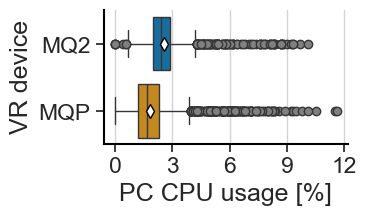

C:\Users\radua\AppData\Local\Temp\ipykernel_24200\256222376.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['is_record'] == rec].sort_values(by='device'), x=component, y='device', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind', flierprops=custom_outliers)


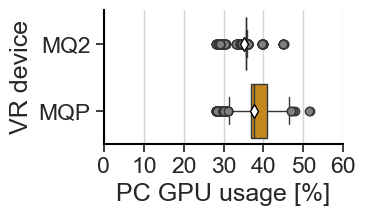

C:\Users\radua\AppData\Local\Temp\ipykernel_24200\256222376.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['is_record'] == rec].sort_values(by='device'), x=component, y='device', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind', flierprops=custom_outliers)


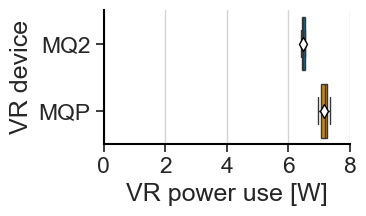

C:\Users\radua\AppData\Local\Temp\ipykernel_24200\256222376.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['is_record'] == rec].sort_values(by='device'), x=component, y='device', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind', flierprops=custom_outliers)


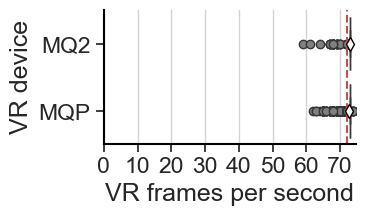

cpu_usage                    count      mean       std  min  25%  50%  75%   max
device is_record                                                      
MQ2    record      260.0  2.224231  1.084708  0.0  1.7  2.1  2.5  10.2
       replay     2509.0  2.564687  1.029914  0.0  2.0  2.4  2.9  10.1
MQP    baseline    794.0  2.305416  1.084260  0.0  1.8  2.2  2.6  14.4
       record      770.0  2.256234  1.480087  0.1  1.4  2.1  2.7  17.3
       replay     7782.0  1.858378  0.983657  0.0  1.2  1.7  2.3  11.6 

gpu_usage                    count       mean       std        min        25%  \
device is_record                                                      
MQ2    record      260.0  34.740572  2.909113  27.314453  35.832520   
       replay     2509.0  35.073684  1.988344  28.134766  35.566406   
MQP    baseline    794.0  40.408754  2.891373  32.119141  41.083984   
       record      770.0  41.472593  2.911040  33.378906  42.021484   
       replay     7782.0  37.703673  3.336602  28.11523

In [320]:
def plot_cpu_usage_simple(df, out_folder, component, xlabel, xrange):
    fig, ax = plt.subplots(1, 1, figsize=(4, 2.5))
    is_record_list = ['replay']
    
    for i, rec in enumerate(is_record_list):
        sns.boxplot(data=df[df['is_record'] == rec].sort_values(by='device'), x=component, y='device', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind', flierprops=custom_outliers)
        if component == 'FPS':
            ax.axvline(x=72, color='r', linestyle='--')
        ax.set_xlabel(xlabel)
        ax.set_ylabel('VR device')

        ax.set_xticks(xrange)

    if component == 'Energy per Second (J/s)':
        component = 'power'
    plt.tight_layout()
    plt.savefig(f'./figures/{out_folder}/PC-A_device_vs_{component}.pdf', bbox_inches='tight', format='pdf')
    plt.show()


full_df['device'] = full_df['device'].apply(lambda x: 'MQ2' if x == 'Quest-2' else ('MQP' if x == 'Quest-Pro' else x))
# plot_gpu_usage_simple(full_df[full_df['host_machine'] == 'PC-A'], 'wkload_offl')
plot_cpu_usage_simple(full_df[full_df['host_machine'] == 'PC-A'], 'wkload_offl', 'cpu_usage', 'PC CPU usage [%]', np.arange(0, 15, 3))
plot_cpu_usage_simple(full_df[full_df['host_machine'] == 'PC-A'], 'wkload_offl', 'gpu_usage', 'PC GPU usage [%]', np.arange(0, 70, 10))
plot_cpu_usage_simple(full_df[full_df['host_machine'] == 'PC-A'], 'wkload_offl', 'Energy per Second (J/s)', 'VR power use [W]', np.arange(0, 9, 2))
plot_cpu_usage_simple(full_lc[full_lc['host_machine'] == 'PC-A'], 'wkload_offl', 'FPS', 'VR frames per second', np.arange(0, 80, 10))


print('cpu_usage', full_df[full_df['host_machine'] == 'PC-A'].groupby(['device', 'is_record'])['cpu_usage'].describe(), '\n')
print('gpu_usage', full_df[full_df['host_machine'] == 'PC-A'].groupby(['device', 'is_record'])['gpu_usage'].describe(), '\n')
print('power', full_df[full_df['host_machine'] == 'PC-A'].groupby(['device', 'is_record'])['Energy per Second (J/s)'].describe(), '\n')
print('FPS', full_lc[full_lc['host_machine'] == 'PC-A'].groupby(['device', 'is_record'])['FPS'].describe(), '\n')


# Statistical test for GPU utilization

In [ ]:
gpu_rec_pca_2 = full_df[(full_df['host_machine'] == 'PC-B') & (full_df['is_record'] == 'replay') & (full_df['device'] == 'Quest-2')]['gpu_usage']
gpu_rec_pca_pro = full_df[(full_df['host_machine'] == 'PC-B') & (full_df['is_record'] == 'replay') & (full_df['device'] == 'Quest-Pro')]['gpu_usage']

# check if gpu usage is normally distributed
from scipy.stats import shapiro
print(shapiro(gpu_rec_pca_2))
print(shapiro(gpu_rec_pca_pro))


# t test for significance
from scipy.stats import ttest_ind
print(ttest_ind(gpu_rec_pca_2, gpu_rec_pca_pro, equal_var=False))


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\radua\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3548, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\radua\AppData\Local\Temp\ipykernel_24200\3249755286.py", line 6, in <module>
    print(shapiro(gpu_rec_pca_2))
          ^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\radua\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py", line 1963, in shapiro
    raise ValueError("Data must be at least length 3.")
ValueError: Data must be at least length 3.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\radua\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 2142, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\radua\AppData\Roaming\Python\Pytho